In [1]:
!python -c "import monai; import nibabel; import tqdm" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)


import torch

print_config()

MONAI version: 1.2.dev2312
Numpy version: 1.21.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 400a6a052f1b2925db6f1323a67a7cf4546403eb
MONAI __file__: /home/user/anaconda3/envs/kevin/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.4.0
Tensorboard version: 2.11.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.6.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.h

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpvfev184y


In [4]:
num_samples = 4

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [5]:
split_json = "dataset_0.json"
data_dir = "/home/user/Documents/unetr/research-contributions/UNETR/BTCV/dataset/dataset0_13/"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# the EnsureTyped transforms allow us to make this distinction
# on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.02s/it]


image shape: torch.Size([1, 255, 223, 276]), label shape: torch.Size([1, 255, 223, 276])


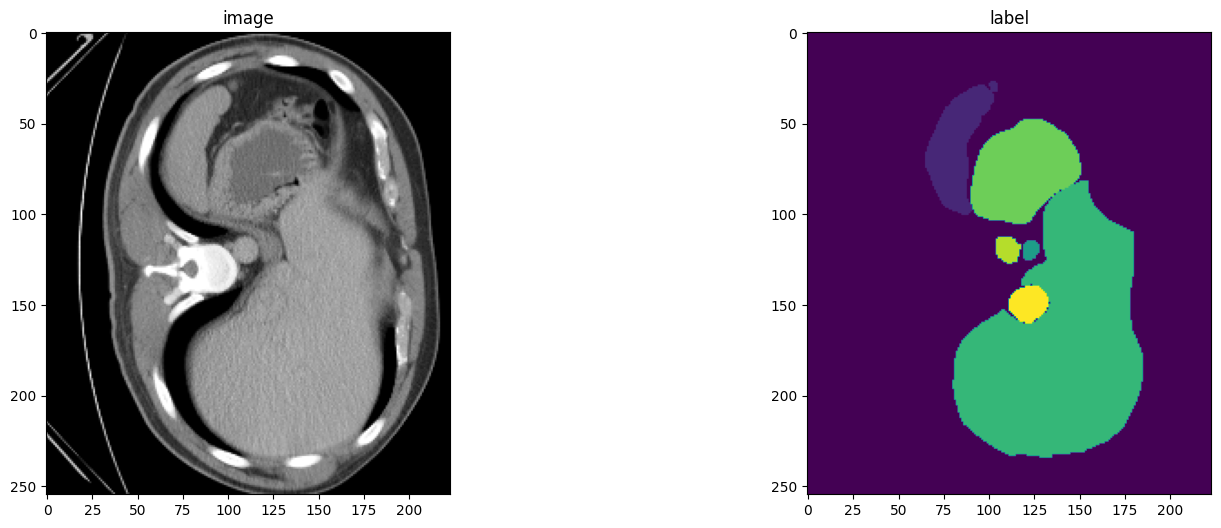

In [6]:
slice_map = {
    "img0035.nii.gz": 170,
    "img0036.nii.gz": 230,
    "img0037.nii.gz": 204,
    "img0038.nii.gz": 204,
    "img0039.nii.gz": 204,
    "img0040.nii.gz": 180,
}
case_num = 1
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
plt.show()

In [7]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=8,
    feature_size=48,
    use_checkpoint=True,
).to(device)

In [8]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

In [9]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val

def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [10]:
max_iterations = 25000#30000
eval_num = 500
post_label = AsDiscrete(to_onehot=14)
post_pred = AsDiscrete(argmax=True, to_onehot=14)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))

Validate (X / X Steps) (dice=X.X):   0%|                                                                                                                                             | 0/6 [00:00<?, ?it/s]None of the inputs have requires_grad=True. Gradients will be None

Training (500 / 25000 Steps) (loss=1.36901):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 21/24 [00:33<00:17,  5.98s/it]

Model Was Saved ! Current Best Avg. Dice: 0.12846754491329193 Current Avg. Dice: 0.12846754491329193


Training (1000 / 25000 Steps) (loss=1.21568):  71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 17/24 [00:30<00:41,  5.86s/it]

Model Was Saved ! Current Best Avg. Dice: 0.20484371483325958 Current Avg. Dice: 0.20484371483325958


Training (1500 / 25000 Steps) (loss=1.30757):  54%|█████████████████████████████████████████████████████████████████                                                       | 13/24 [00:26<01:04,  5.87s/it]

Model Was Saved ! Current Best Avg. Dice: 0.3809436857700348 Current Avg. Dice: 0.3809436857700348


Training (2000 / 25000 Steps) (loss=0.99872):  38%|█████████████████████████████████████████████▍                                                                           | 9/24 [00:23<01:29,  6.00s/it]

Model Was Saved ! Current Best Avg. Dice: 0.515916645526886 Current Avg. Dice: 0.515916645526886


Training (2500 / 25000 Steps) (loss=1.05193):  21%|█████████████████████████▏                                                                                               | 5/24 [00:20<02:09,  6.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.5962079167366028 Current Avg. Dice: 0.5962079167366028


Training (3000 / 25000 Steps) (loss=0.98398):   4%|█████                                                                                                                    | 1/24 [00:17<06:43, 17.55s/it]

Model Was Saved ! Current Best Avg. Dice: 0.622393012046814 Current Avg. Dice: 0.622393012046814


Training (3500 / 25000 Steps) (loss=0.77641):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 21/24 [00:32<00:17,  5.78s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6236701607704163 Current Avg. Dice: 0.6236701607704163


Training (4000 / 25000 Steps) (loss=0.87522):  71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 17/24 [00:29<00:40,  5.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6786028742790222 Current Avg. Dice: 0.6786028742790222


Training (4500 / 25000 Steps) (loss=1.15808):  54%|█████████████████████████████████████████████████████████████████                                                       | 13/24 [00:26<01:04,  5.82s/it]

Model Was Saved ! Current Best Avg. Dice: 0.6979197859764099 Current Avg. Dice: 0.6979197859764099


Training (5000 / 25000 Steps) (loss=1.09686):  38%|█████████████████████████████████████████████▍                                                                           | 9/24 [00:23<01:28,  5.92s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.6979197859764099 Current Avg. Dice: 0.6786727905273438


Training (5500 / 25000 Steps) (loss=0.73076):  21%|█████████████████████████▏                                                                                               | 5/24 [00:20<02:09,  6.80s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7780043482780457 Current Avg. Dice: 0.7780043482780457


Training (6000 / 25000 Steps) (loss=0.65476):   4%|█████                                                                                                                    | 1/24 [00:17<06:43, 17.53s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7886735796928406 Current Avg. Dice: 0.7886735796928406


Training (6500 / 25000 Steps) (loss=0.80090):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 21/24 [00:32<00:17,  5.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7922140955924988 Current Avg. Dice: 0.7922140955924988


Training (7000 / 25000 Steps) (loss=0.71997):  71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 17/24 [00:29<00:40,  5.79s/it]

Model Was Saved ! Current Best Avg. Dice: 0.7971675992012024 Current Avg. Dice: 0.7971675992012024


Training (7500 / 25000 Steps) (loss=0.66246):  54%|█████████████████████████████████████████████████████████████████                                                       | 13/24 [00:26<01:04,  5.85s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8049928545951843 Current Avg. Dice: 0.8049928545951843


Training (8000 / 25000 Steps) (loss=0.78324):  38%|█████████████████████████████████████████████▍                                                                           | 9/24 [00:23<01:30,  6.01s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8130242228507996 Current Avg. Dice: 0.8130242228507996


Training (8500 / 25000 Steps) (loss=0.70534):  21%|█████████████████████████▏                                                                                               | 5/24 [00:20<02:07,  6.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8130242228507996 Current Avg. Dice: 0.8062596321105957


Training (9000 / 25000 Steps) (loss=0.77857):   4%|█████                                                                                                                    | 1/24 [00:17<06:37, 17.26s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8130242228507996 Current Avg. Dice: 0.8051508069038391


Training (9500 / 25000 Steps) (loss=0.80192):  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 21/24 [00:32<00:17,  5.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8130242228507996 Current Avg. Dice: 0.8063530921936035


Training (10000 / 25000 Steps) (loss=0.62359):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:29<00:39,  5.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8130242228507996 Current Avg. Dice: 0.8058612942695618


Training (10500 / 25000 Steps) (loss=0.84037):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:26<01:04,  5.83s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8192149996757507 Current Avg. Dice: 0.8192149996757507


Training (11000 / 25000 Steps) (loss=0.64140):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:23<01:28,  5.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8192149996757507 Current Avg. Dice: 0.8170602917671204


Training (11500 / 25000 Steps) (loss=0.48299):  21%|█████████████████████████                                                                                               | 5/24 [00:20<02:07,  6.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8192149996757507 Current Avg. Dice: 0.8099501729011536


Training (12000 / 25000 Steps) (loss=0.60614):   4%|█████                                                                                                                   | 1/24 [00:17<06:37, 17.28s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8192149996757507 Current Avg. Dice: 0.8187492489814758


Training (12500 / 25000 Steps) (loss=0.80963):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:32<00:17,  5.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8192149996757507 Current Avg. Dice: 0.8044299483299255


Training (13000 / 25000 Steps) (loss=0.83930):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:29<00:40,  5.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8192149996757507 Current Avg. Dice: 0.8165125846862793


Training (13500 / 25000 Steps) (loss=0.51736):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:26<01:03,  5.77s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8192149996757507 Current Avg. Dice: 0.8138667941093445


Training (14000 / 25000 Steps) (loss=0.35788):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:23<01:28,  5.93s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8192149996757507 Current Avg. Dice: 0.8169026374816895


Training (14500 / 25000 Steps) (loss=0.73068):  21%|█████████████████████████                                                                                               | 5/24 [00:20<02:08,  6.74s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8192149996757507 Current Avg. Dice: 0.7895998358726501


Training (15000 / 25000 Steps) (loss=0.47458):   4%|█████                                                                                                                   | 1/24 [00:17<06:36, 17.23s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8192149996757507 Current Avg. Dice: 0.7962512969970703


Training (15500 / 25000 Steps) (loss=0.72758):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:32<00:17,  5.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8192149996757507 Current Avg. Dice: 0.8010658621788025


Training (16000 / 25000 Steps) (loss=0.49959):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:30<00:40,  5.83s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8235923647880554 Current Avg. Dice: 0.8235923647880554


Training (16500 / 25000 Steps) (loss=0.60718):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:26<01:03,  5.81s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8235923647880554 Current Avg. Dice: 0.8174569010734558


Training (17000 / 25000 Steps) (loss=0.79950):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:23<01:29,  5.99s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8251462578773499 Current Avg. Dice: 0.8251462578773499


Training (17500 / 25000 Steps) (loss=0.52902):  21%|█████████████████████████                                                                                               | 5/24 [00:20<02:07,  6.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8251462578773499 Current Avg. Dice: 0.8164420127868652


Training (18000 / 25000 Steps) (loss=0.66904):   4%|█████                                                                                                                   | 1/24 [00:17<06:38, 17.31s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8251462578773499 Current Avg. Dice: 0.8128369450569153


Training (18500 / 25000 Steps) (loss=0.51255):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:33<00:17,  5.81s/it]

Model Was Saved ! Current Best Avg. Dice: 0.825878918170929 Current Avg. Dice: 0.825878918170929


Training (19000 / 25000 Steps) (loss=0.38784):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:29<00:40,  5.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.825878918170929 Current Avg. Dice: 0.8086420893669128


Training (19500 / 25000 Steps) (loss=0.57096):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:26<01:03,  5.75s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.825878918170929 Current Avg. Dice: 0.8156886100769043


Training (20000 / 25000 Steps) (loss=0.58044):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:23<01:28,  5.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.825878918170929 Current Avg. Dice: 0.8142797350883484


Training (20500 / 25000 Steps) (loss=0.53207):  21%|█████████████████████████                                                                                               | 5/24 [00:20<02:07,  6.73s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.825878918170929 Current Avg. Dice: 0.8227598071098328


Training (21000 / 25000 Steps) (loss=0.62215):   4%|█████                                                                                                                   | 1/24 [00:17<06:42, 17.51s/it]

Model Was Saved ! Current Best Avg. Dice: 0.8271095156669617 Current Avg. Dice: 0.8271095156669617


Training (21500 / 25000 Steps) (loss=0.70268):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:32<00:17,  5.71s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8271095156669617 Current Avg. Dice: 0.8170267939567566


Training (22000 / 25000 Steps) (loss=0.64408):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:29<00:40,  5.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8271095156669617 Current Avg. Dice: 0.813976526260376


Training (22500 / 25000 Steps) (loss=0.65454):  54%|████████████████████████████████████████████████████████████████▍                                                      | 13/24 [00:26<01:03,  5.79s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8271095156669617 Current Avg. Dice: 0.8246685862541199


Training (23000 / 25000 Steps) (loss=0.25802):  38%|█████████████████████████████████████████████                                                                           | 9/24 [00:23<01:28,  5.91s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8271095156669617 Current Avg. Dice: 0.8203380107879639


Training (23500 / 25000 Steps) (loss=0.36343):  21%|█████████████████████████                                                                                               | 5/24 [00:20<02:07,  6.70s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8271095156669617 Current Avg. Dice: 0.8151953816413879


Training (24000 / 25000 Steps) (loss=0.70025):   4%|█████                                                                                                                   | 1/24 [00:17<06:36, 17.24s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.8271095156669617 Current Avg. Dice: 0.8222162127494812


Training (24500 / 25000 Steps) (loss=0.63585):  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 21/24 [00:32<00:17,  5.77s/it]

Model Was Saved ! Current Best Avg. Dice: 0.828331470489502 Current Avg. Dice: 0.828331470489502


Training (25000 / 25000 Steps) (loss=0.63831):  71%|████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/24 [00:29<00:40,  5.72s/it]

Model Was Not Saved ! Current Best Avg. Dice: 0.828331470489502 Current Avg. Dice: 0.8265278339385986


Training (25007 / 25000 Steps) (loss=0.63782): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:35<00:00,  1.46s/it]


<All keys matched successfully>

In [11]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.8283 at iteration: 24500


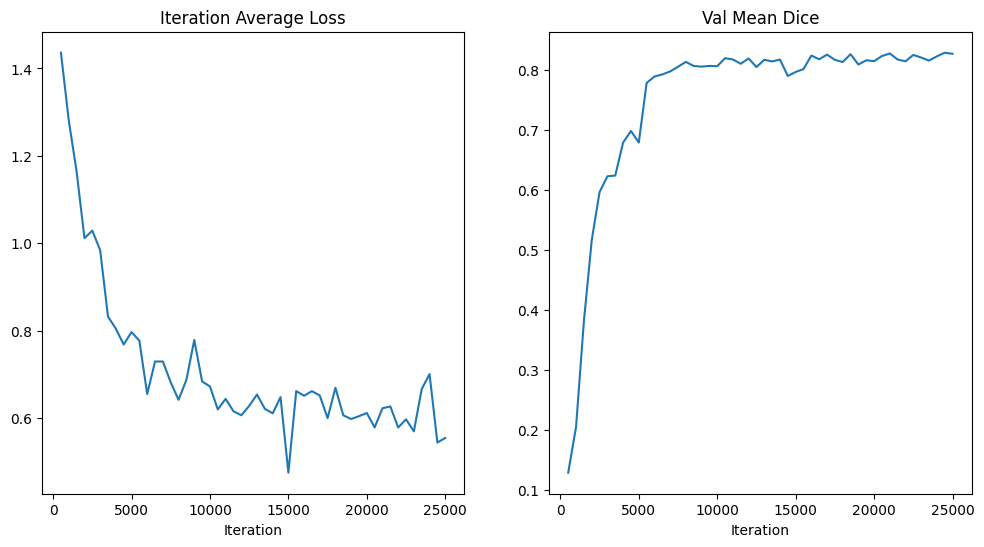

In [12]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

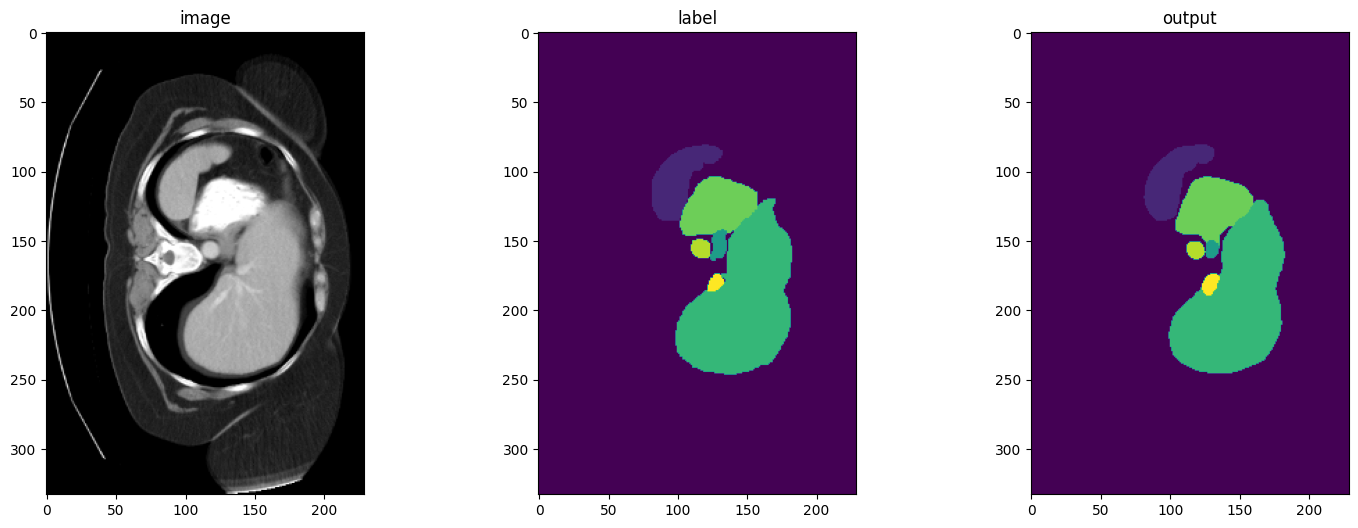

In [13]:
case_num = 4
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_map[img_name]], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_map[img_name]])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_map[img_name]])
    plt.show()